In [1]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

import stackstac
import dask.array as da
import pystac_client
import geopandas as gpd
import planetary_computer as pc
import xarray as xr

import os

from PIL import Image, ImageDraw, ImageFont
from xarray.plot.utils import _rescale_imshow_rgb
import numpy as np
from typing import TYPE_CHECKING, BinaryIO, cast,Literal
import ntpath

# Define general variables

setting = {'spatial_resolution' : 500,
            'cloud_cover': 20}

glacier = "thwaites"
full_name= "Thwaites"

#glacier = "amundsen"
#full_name= "Amundsen bay"


def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation
    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

# define font size for Label
def fontSize(arr):
    img = Image.fromarray(arr)
    txt = "Hello World"
    fontsize = 1  # starting font size
    font = ImageFont.truetype("Calibri.ttf", fontsize)
    # portion of image width you want text width to be
    img_fraction = 0.10
    breakpoint = img_fraction * min(img.size[0],img.size[1])
    jumpsize = 75
    while True:
        if font.getlength(txt) < breakpoint:
            fontsize += jumpsize
        else:
            jumpsize = jumpsize // 2
            fontsize -= jumpsize
        font = ImageFont.truetype('Calibri.ttf', fontsize)
        if jumpsize <= 1:
            break

    return fontsize

def save_img(arr: xr.DataArray,
             timeStamp: bool = True,
             fontsize: int = 35,
             glacier:str = '.',
             date_position: Literal["ul", "ur", "ll", "lr"] = "ul",
             date_color: tuple[int, int, int] = (0, 0, 0),
             date_bg: tuple[int, int, int]  = (255, 255, 255)):
        
    date_img = str(arr.time.values)[0:10]
    # Rescale
    vmin = np.nanmin(arr)
    vmax = np.nanmax(arr)
    data= _rescale_imshow_rgb(arr, vmin, vmax, True)

    # convert to U8
    u8 = (data * 255).astype("uint8").to_numpy()
    u8 = np.clip(u8, 0, 255, out=u8)
    u8 = np.moveaxis(u8, -3, -1) #??
    # Add alpha mask
    mask: np.ndarray = arr.isnull().data.any(axis=-3)
    alpha = (~mask).astype("uint8", copy=False) * 255
    frame = np.concatenate([u8, alpha[..., None]], axis=-1)

    #imgs = [Image.fromarray(frame) for frame in frames]
    img = Image.fromarray(frame)
    
     # Write timestamps onto each frame
       
    fnt =ImageFont.truetype("Calibri.ttf", fontsize)
    if timeStamp:
        
        label1 = full_name 
        label2 = 'Summer ' + date_img
        
        # get a drawing context
        d = ImageDraw.Draw(img)
        d = cast(ImageDraw.ImageDraw, d)

        width, height = img.size
        left, top, right, bottom = fnt.getbbox(label1)
        t_width = fnt.getlength(label1)
        t_height = abs(top - bottom)
        
        offset = max(0.03*width,0.03*height)
        if date_position[0] == "u":
            y = offset
        else:
            y = height - t_height - offset

        if date_position[1] == "l":
            x = offset
        else:
            x = width - t_width - offset

        border = t_height*0.1
        #if date_bg:
           # d.rectangle([(x-border, y-border),(x + t_width  , y + t_height)], fill=date_bg)
            #d.rectangle((x-border, y+2*t_height-border, x + t_width  + border, y+ 2*t_height + t_height+border), fill=date_bg)
        # draw text
        d.multiline_text((x, y), label1, font=fnt, fill=date_color)
        d.multiline_text((x, y+2*t_height), label2, font=fnt, fill=date_color)

    
    out_filename = os.path.join(os.getcwd(),glacier,ntpath.basename(filename).split('.')[0]+'_'+ date_img + '.png')
    
    img.save(
        out_filename,
        format="png"
    )
    print (glacier +': '+ date_img +' processed')

if __name__ == '__main__':
    cluster = SLURMCluster(
        #queue='regular',
        account="wp1",
        cores=20,
        memory="75 GB"
    )
    cluster.scale(jobs=10)  # ask for 10 jobs
    client = Client(cluster)
    print(client)


    #filename = "geojson file path"
    filename = glacier +".geojson"
    
    # read in AOI as a GeoDataFrame
    aoi = gpd.read_file(filename)
    bbox =aoi.unary_union.bounds

    # With the pystac_client module’s Client class, Open the STAC API. 
    datetimeRange=[]
    for t in range (2020,2022):
        datetimeRange.append(str(t)+"-01-01/"+str(t)+"-03-30")

    LandsatSTAC = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

    for dt in datetimeRange:    
        search = (
            LandsatSTAC
            .search(
                bbox=bbox,
                datetime = dt, 
                collections = ["modis-09A1-061"]
            )
        )
        
        items = pc.sign(search)
        
        print(dt +': ' +str(len(items))+ ' scenes found')

        stack = stackstac.stack(items,bounds_latlon=bbox,epsg=3031, resolution=setting['spatial_resolution'])

<Client: 'tcp://129.88.193.194:43019' processes=0 threads=0, memory=0 B>
2020-01-01/2020-03-30: 26 scenes found
2021-01-01/2021-03-30: 26 scenes found


In [4]:
composites = stack.sel(band=["sur_refl_b01", "sur_refl_b04", "sur_refl_b03"])
composites.ffill("time").bfill("time")

,Array,Chunk
Bytes,93.21 MiB,1.20 MiB
Shape,"(26, 3, 458, 342)","(1, 1, 458, 342)"
Count,10 Graph Layers,78 Chunks
Type,float64,numpy.ndarray


In [6]:
ts = composites.persist()
ts_local = ts.compute()

# define the font size
fontsize = fontSize(ts_local.isel(time=0)[0].to_numpy())
for t in ts_local['time']:
    save_img(ts_local.sel(time=t), fontsize=fontsize, glacier=glacier,date_position="lr")

ValueError: different number of dimensions on data and dims: 1 vs 0

In [9]:
ts_local

<xarray.DataArray 'stackstac-4b7038d1a2a398c94bfc3dea64b4bf5a' (time: 26,
                                                                band: 3,
                                                                y: 458, x: 342)>
array([[[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [ 9732.,  9481.,  9481., ...,    nan,    nan,    nan],
         [ 9732.,  9688.,  9688., ...,    nan,    nan,    nan],
         [ 4672.,  9732.,  9688., ...,    nan,    nan,    nan]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [ 9819.,  9587.,  9587., ...,    nan,    nan,    nan],
         [ 9819.,  9778.,  9778., ...,    nan,    nan,    nan],
         [ 5660.,  9819.,  9778., ...,    nan,    nan,    nan]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
...
         ...,
         [ 4462.,  1351.,  8288., ...,    nan,    nan,    nan],
         [ 7619.,  5244.,  9594., ...,    nan,    nan,    nan],
         [ 8595.,  7619.,  6768., ...,    nan,    nan,    nan]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [ 5056.,  1549.,  8640., ...,    nan,    nan,    nan],
         [ 8041.,  5307.,  9844., ...,    nan,    nan,    nan],
         [ 8861.,  8041.,  7220., ...,    nan,    nan,    nan]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [ 5441.,  2118.,  8725., ...,    nan,    nan,    nan],
         [ 8225.,  5789.,  9816., ...,    nan,    nan,    nan],
         [ 8965.,  8225.,  7509., ...,    nan,    nan,    nan]]]])
Coordinates: (12/25)
  * time                   (time) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT
    id                     (time) <U41 'MYD09A1.A2021089.h14v16.061.202109805...
  * band                   (band) <U20 'sur_refl_b01' ... 'sur_refl_b03'
  * x                      (x) float64 -1.68e+06 -1.679e+06 ... -1.509e+06
  * y                      (y) float64 -3.685e+05 -3.69e+05 ... -5.97e+05
    proj:wkt2              <U424 'PROJCS["unnamed",GEOGCS["Unknown datum base...
    ...                     ...
    title                  (band) <U51 'Surface Reflectance Band 1 (620-670 n...
    raster:bands           (band) object {'scale': 0.0001, 'data_type': 'int1...
    common_name            (band) object 'red' 'green' 'blue'
    center_wavelength      (band) object 0.645 0.555 0.469
    full_width_half_max    (band) object 0.5 0.2 0.2
    epsg                   int64 3031
Attributes:
    spec:        RasterSpec(epsg=3031, bounds=(-1679500, -597500, -1508500, -...
    crs:         epsg:3031
    transform:   | 500.00, 0.00,-1679500.00|\n| 0.00,-500.00,-368500.00|\n| 0...
    resolution:  500

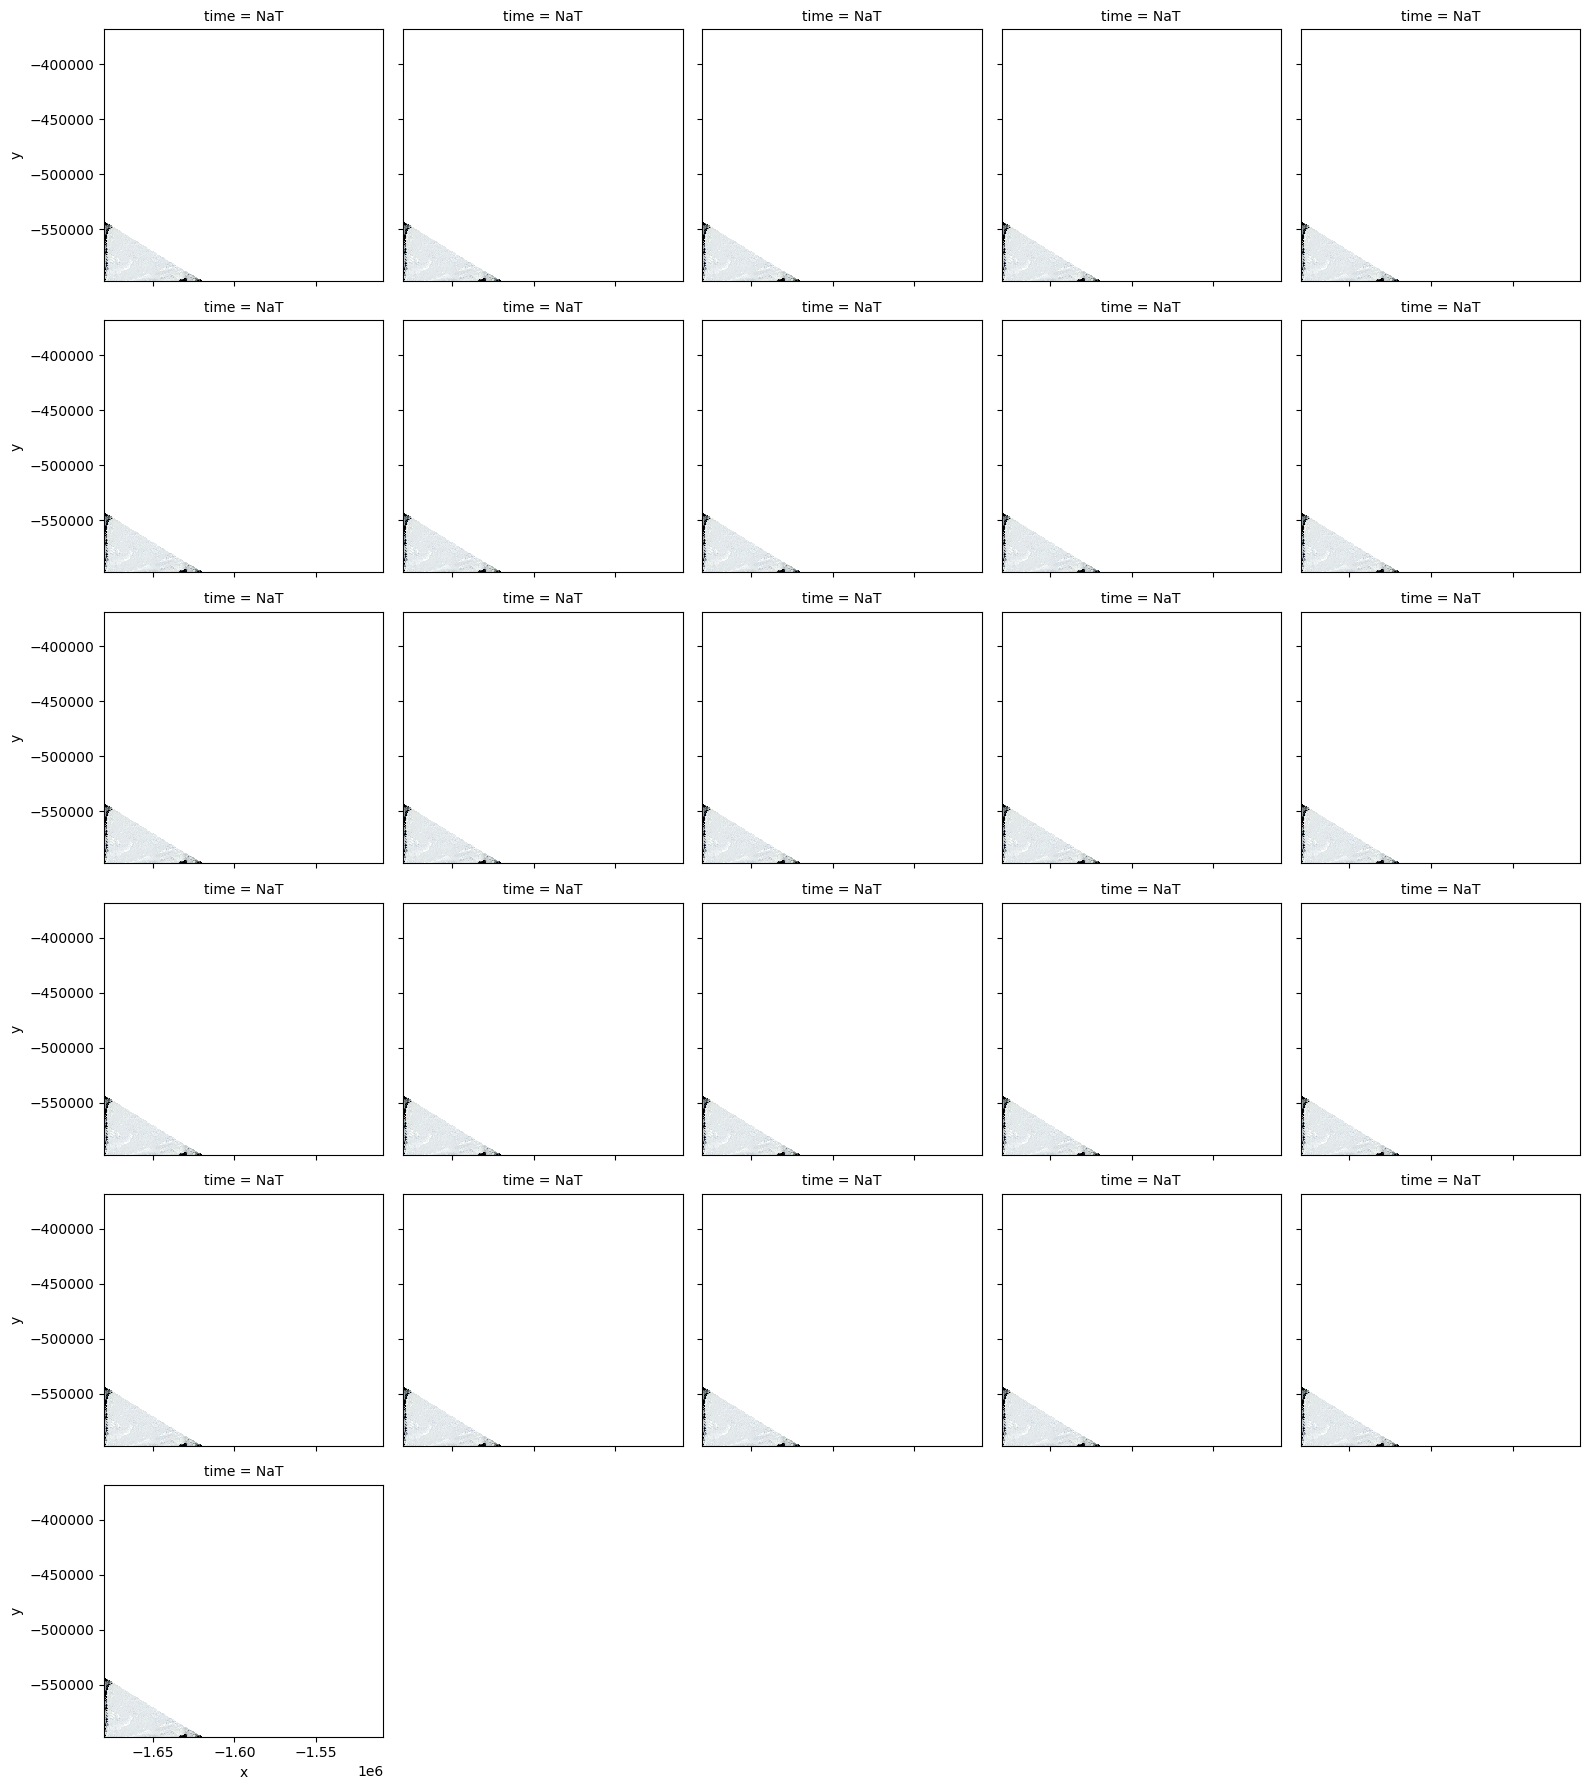

In [10]:
ts_local.plot.imshow(col="time", rgb="band", col_wrap=5, robust=True)